## 0. Generate a language

We first build the pregroup diagrams for a simple subject-verb-object language.

8*3*8 = 192 sentences:
Alice loves Alice
Alice loves Bob
Alice loves Charlie
...
Isabel kills Fred
Isabel kills George
Isabel kills Isabel



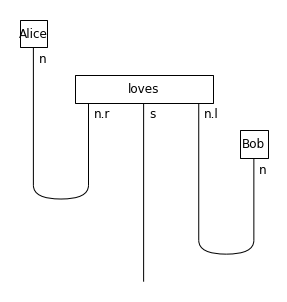

Pregroup diagram for 'Alice loves Bob'


In [1]:
from discopy import Ty, Word, Cup, Id

nouns = ["Alice", "Bob", "Charlie", "Diane", "Eve", "Fred", "George", "Isabel"]
verbs = ["loves", "hates", "kills"]

s, n = Ty('s'), Ty('n')
tv = n.r @ s @ n.l

vocab = [Word(noun, n) for noun in nouns] + [Word(verb, tv) for verb in verbs]

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

sentences = [
    "{} {} {}".format(subj, verb, obj)
    for subj in nouns for verb in verbs for obj in nouns]

print("{}*{}*{} = {} sentences:\n{}\n".format(
    len(nouns), len(verbs), len(nouns), len(sentences), "\n".join(sentences[:3] + ["..."] + sentences[-3:])))

diagrams = {
    sentence: Word(subj, n) @ Word(verb, tv) @ Word(obj, n) >> grammar
    for sentence in sentences for subj, verb, obj in [sentence.split(' ')]}

diagrams[sentences[1]].draw()
print("Pregroup diagram for '{}'".format(sentences[1]))

## 1. Build a random dataset

We then generate a toy dataset with scalars attached to each diagram.

In order to do so, we apply a random functor from Pregroup to Tensor to each diagram in the corpus.

A `TensorFunctor` is defined by two mappings `ob` from types to dimension (i.e. hyper-parameters) and `ar` from words to matrices (i.e. parameters).

In [2]:
import jax.numpy as np; import numpy; np.random = numpy.random; np.random.seed(42)
from discopy import TensorFunctor

# N.B. defining ob[tv] is not necessary, indeed F(tv) == F(n) * F(s) * F(n)
ob = {n: 2, s: 1, tv: 4}
ar0 = {word: np.random.randn(ob[word.cod]) for word in vocab}
F0 = TensorFunctor(ob, ar0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

dataset = {sentence: sigmoid(F0(diagram).array) for sentence, diagram in diagrams.items()}
y_true = [float(y) for y in dataset.values()]

Let's have a look at what this random dataset looks like:

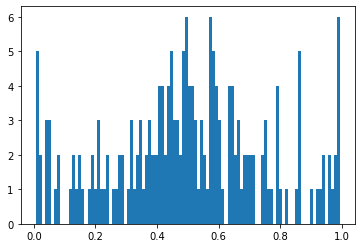

In [3]:
from matplotlib import pyplot as plt

plt.hist(y_true, bins=100)
plt.show()

In [4]:
from random import shuffle

delta = 0.1

true_sentences = [sentence for sentence in dataset if dataset[sentence] > 0.5 + delta]
shuffle(true_sentences)
print("{} true sentences:\n{}\n".format(
    len(true_sentences), "\n".join(true_sentences[:3] + ['...'] + true_sentences[-3:])))

61 true sentences:
George kills Alice
Isabel kills George
George hates Bob
...
Bob kills Fred
George hates Eve
Isabel hates Eve



In [5]:
print("Does Alice love Bob?\n{}".format(
    "Yes" if dataset["Alice loves Bob"] > 0.5 + delta else "No"))

Does Alice love Bob?
No


## 2. Learn the functor from data

We split the dataset into training and testing.
We forget `F0` and initialise some new random functor.

We define the mean squared loss on testing and training set and compile them just-in-time.

We use automatic differentiation and vanilla gradient descent to learn the parameters for the functor.

In [6]:
from sklearn.model_selection import train_test_split

training, testing = train_test_split(sentences, test_size=0.25, random_state=42)

def loss(ar, sample=training):
    F = TensorFunctor(ob, ar)
    y_pred = [sigmoid(F(diagrams[sentence]).array) for sentence in sample]
    y_true = [dataset[sentence] for sentence in sample]
    return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

ar = {word: np.random.randn(ob[word.cod]) for word in vocab}

print("Initial training loss: {}\nInitial testing loss: {}".format(loss(ar), loss(ar, testing)))

Initial training loss: 0.12394743412733078
Initial testing loss: 0.10969964414834976


In [7]:
from time import time
from jax import jit, grad

training_loss = jit(loss)
testing_loss = jit(lambda ar: loss(ar, testing))
gradient = jit(grad(training_loss))
start = time()

print("{1:.0f} seconds to just-in-time compile the gradient:\n{0}".format("\n".join(
    "{}: {}".format(word, dx) for word, dx in gradient(ar).items()), time() - start))

113 seconds to just-in-time compile the gradient:
Alice: [-0.01686156 -0.01012888]
Bob: [-0.0085393   0.00930784]
Charlie: [-0.00412429 -0.01343251]
Diane: [ 0.00908923 -0.00716087]
Eve: [-0.00673484 -0.0107691 ]
Fred: [-0.01174346 -0.00308988]
George: [0.01267174 0.01413585]
Isabel: [-0.00672528 -0.02229434]
hates: [-0.00208589 -0.00725513  0.00607718 -0.00264032]
kills: [-0.00403996  0.00772784  0.00631926  0.00695181]
loves: [-0.00456121 -0.0044004  -0.00093371  0.01333533]


Epoch 1 (55.945 seconds)
Epoch 2 (0.932 seconds)
Epoch 3 (0.919 seconds)
Epoch 4 (0.958 seconds)
Epoch 5 (0.896 seconds)
Epoch 6 (0.884 seconds)
Epoch 7 (1.262 seconds)
Epoch 8 (0.971 seconds)
Epoch 9 (1.115 seconds)
Epoch 10 (1.014 seconds)


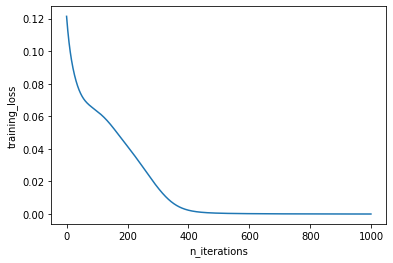

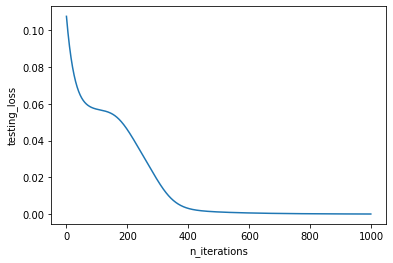

In [8]:
learning_rate = 1
epochs = 10
iterations = 100

training_losses = []
testing_losses = []

for i in range(epochs):
    start = time()
    for _ in range(iterations):
        g = gradient(ar)
        for word in vocab:
            ar[word] = ar[word] - g[word] * learning_rate
        training_losses.append(float(training_loss(ar)))
        testing_losses.append(float(testing_loss(ar)))
    print("Epoch {} ({:.3f} seconds)".format(i + 1, time() - start))

F = TensorFunctor(ob, ar)
y_pred = [float(sigmoid(F(diagrams[sentence]).array)) for sentence in sentences]

plt.plot(training_losses)
plt.xlabel("n_iterations")
plt.ylabel("training_loss")
plt.show()

plt.plot(testing_losses)
plt.xlabel("n_iterations")
plt.ylabel("testing_loss")
plt.show()

## 3. Evaluate the learnt functor on some task

Here we show the results for a binary classification task, i.e. yes-no question answering:

In [9]:
from sklearn.metrics import classification_report

print(classification_report(np.array(y_true) > .5 + delta, np.array(y_pred) > .5 + delta))

              precision    recall  f1-score   support

       False       0.99      1.00      1.00       131
        True       1.00      0.98      0.99        61

    accuracy                           0.99       192
   macro avg       1.00      0.99      0.99       192
weighted avg       0.99      0.99      0.99       192



In [10]:
print("Does Alice love Bob?\n{}".format(
    "Yes" if y_pred[sentences.index("Alice loves Bob")] > 0.5 + delta else "No"))

Does Alice love Bob?
No
